In [0]:
import sys
import os
import gc
import warnings
import torch

import torch.nn as nn
import numpy as np
import pandas as pd 
import torch.nn.functional as F

from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [3]:
np.random.seed(23)
torch.cuda.device(0)
warnings.filterwarnings("ignore")
torch.multiprocessing.freeze_support()
print("[INFO] GPU:", torch.cuda.get_device_name())

[INFO] GPU: Tesla P100-PCIE-16GB


In [0]:
  def get_data(size, batch_size):
    """
    function that returns a DataBunch as needed for the Learner
    """
    train = pd.read_csv("/content/drive/My Drive/av/train.csv")
    src = (ImageList.from_df(train, path = '/', folder="content/drive/My Drive/av/train").split_by_rand_pct(0.1).label_from_df())
    src.add_test_folder("/content/drive/My Drive/av/test/")
    tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, 
                        max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

    data = (src.transform(
        tfms,
        size=size,
        resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))
    assert sorted(set(train.emergency_or_not.unique())) == sorted(data.classes), "Class Mismatch"
    print("[INFO] Number of Classes: ", data.c)
    data.num_workers = 4
    return data

[INFO] Number of Classes:  2


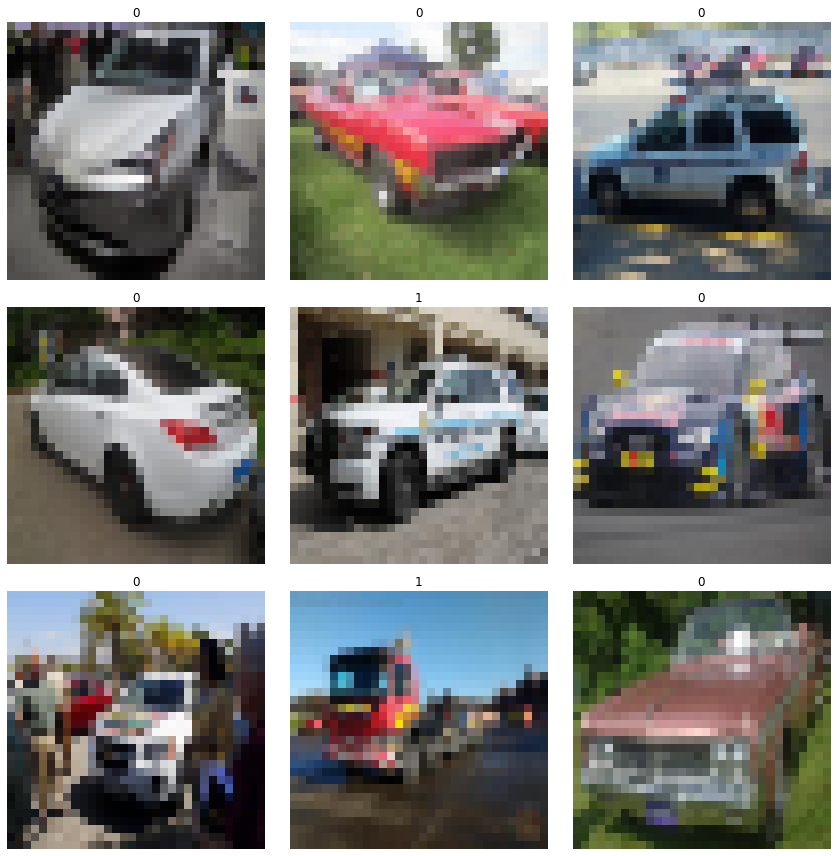

In [5]:
sample_data = get_data(32, (2048//32))
sample_data.show_batch(3, 3)

In [6]:
learn = create_cnn(get_data(32, (2048//32)), models.densenet161, 
                   metrics=[accuracy, FBeta(beta=1,average='macro')])
learn.model_dir = "models/"
learn.save("densenet_32")

learn = create_cnn(get_data(64, (2048//64)), models.densenet161, 
                   metrics=[accuracy, FBeta(beta=1,average='macro')]).load("densenet_32")
learn.model_dir = "models/"
learn.save("densenet_64")

learn = create_cnn(get_data(128, (2048//128)), models.densenet161, 
                   metrics=[accuracy, FBeta(beta=1,average='macro')]).load("densenet_64")
learn.model_dir = "models/"
learn.save("densenet_128")

learn = create_cnn(get_data(256, (2048//256)), models.densenet161, 
                   metrics=[accuracy, FBeta(beta=1,average='macro')]).load("densenet_128")
learn.model_dir = "models/"
learn.save("densenet_256") 

[INFO] Number of Classes:  2


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth



[INFO] Number of Classes:  2
[INFO] Number of Classes:  2
[INFO] Number of Classes:  2


In [0]:
def train_model(size, iter1, iter2, mixup=False):
  """
  function to quickly train a model for a certain number of iterations.
  """
  size_match = {"256": "128", "128": "64", "64": "32"}
  learn = create_cnn(get_data(size, (2048//size)), models.densenet161, 
                     metrics=[accuracy, 
                              FBeta(beta=1,average='macro')])
  learn.model_dir = "models/"
  if mixup:
    learn.mixup()
  if str(size) != str(32):
    learn.load("densenet_" + str(size_match[str(size)]))

  name = "densenet_" + str(size)
  print("[INFO] Training for : ", name)

  learn.fit_one_cycle(iter1, 1e-4, callbacks=[ShowGraph(learn),
                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])
  learn.unfreeze()
  learn.fit_one_cycle(iter2, 5e-5, callbacks=[ShowGraph(learn),
                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])

[INFO] Number of Classes:  2
[INFO] Training for :  densenet_32


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.277838,0.737203,0.536585,0.534091,03:04
1,1.239064,0.717360,0.591463,0.591327,00:07
2,1.179929,0.666072,0.640244,0.640123,00:07
3,1.112930,0.638201,0.695122,0.694395,00:07
4,1.018945,0.519602,0.768293,0.764795,00:07
5,0.948141,0.469365,0.768293,0.765467,00:07
6,0.877979,0.575656,0.731707,0.729129,00:07
7,0.830825,0.510647,0.756098,0.751628,00:07
8,0.760337,0.634191,0.743902,0.740780,00:07
9,0.731487,0.834715,0.725610,0.721877,00:07


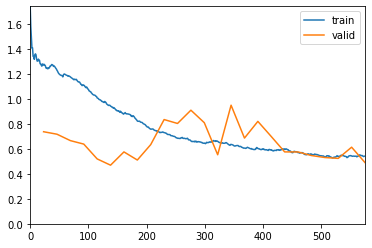

Better model found at epoch 0 with f_beta value: 0.5340908765792847.
Better model found at epoch 1 with f_beta value: 0.5913266539573669.
Better model found at epoch 2 with f_beta value: 0.6401234865188599.
Better model found at epoch 3 with f_beta value: 0.6943947672843933.
Better model found at epoch 4 with f_beta value: 0.7647947072982788.
Better model found at epoch 5 with f_beta value: 0.7654674053192139.
Better model found at epoch 19 with f_beta value: 0.7713209390640259.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.579119,0.543172,0.756098,0.752415,00:07
1,0.547222,0.483645,0.762195,0.759612,00:07
2,0.547366,0.456627,0.774390,0.769864,00:07
3,0.558270,0.552253,0.768293,0.762319,00:07
4,0.538115,0.505828,0.792683,0.786458,00:07
5,0.515543,0.703429,0.756098,0.747653,00:07
6,0.476037,0.959786,0.780488,0.771800,00:07
7,0.470915,0.536014,0.768293,0.763222,00:07
8,0.444721,0.489266,0.750000,0.739451,00:07
9,0.429544,0.646928,0.750000,0.744052,00:07


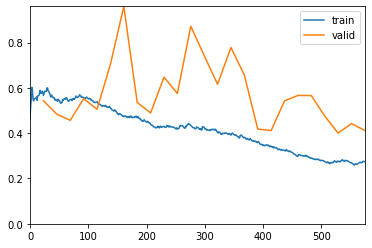

Better model found at epoch 0 with f_beta value: 0.7524154186248779.
Better model found at epoch 1 with f_beta value: 0.7596121430397034.
Better model found at epoch 2 with f_beta value: 0.7698638439178467.
Better model found at epoch 4 with f_beta value: 0.7864583730697632.
Better model found at epoch 14 with f_beta value: 0.796114981174469.
Better model found at epoch 15 with f_beta value: 0.798122763633728.
Better model found at epoch 16 with f_beta value: 0.7990196347236633.
Better model found at epoch 20 with f_beta value: 0.8115808963775635.
Better model found at epoch 23 with f_beta value: 0.8157088756561279.


In [8]:
train_model(32, 25, 25)

[INFO] Number of Classes:  2
[INFO] Training for :  densenet_64


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.676713,0.367530,0.859756,0.856420,00:12
1,0.657920,0.334603,0.890244,0.888233,00:10
2,0.597402,0.400885,0.871951,0.870560,00:10
3,0.575024,0.321305,0.902439,0.900304,00:10
4,0.535890,0.311497,0.884146,0.882215,00:10
5,0.485995,0.427254,0.908537,0.907012,00:10
6,0.475499,0.349979,0.884146,0.882570,00:10
7,0.471684,0.276966,0.914634,0.912433,00:10
8,0.456055,0.259358,0.926829,0.924632,00:10
9,0.452812,0.272368,0.920732,0.918846,00:10


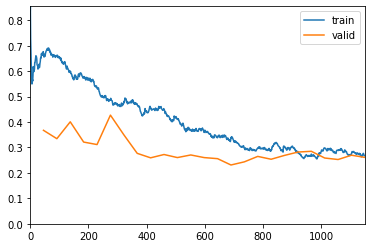

Better model found at epoch 0 with f_beta value: 0.8564196228981018.
Better model found at epoch 1 with f_beta value: 0.8882325887680054.
Better model found at epoch 3 with f_beta value: 0.9003039598464966.
Better model found at epoch 5 with f_beta value: 0.9070119261741638.
Better model found at epoch 7 with f_beta value: 0.9124332666397095.
Better model found at epoch 8 with f_beta value: 0.9246324300765991.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.399917,0.262239,0.908537,0.905147,00:11
1,0.364101,0.261698,0.926829,0.925488,00:10
2,0.374783,0.288201,0.908537,0.906702,00:11
3,0.361714,0.285033,0.902439,0.900304,00:11
4,0.347216,0.305229,0.890244,0.887414,00:11
5,0.295067,0.278088,0.896341,0.893875,00:10
6,0.296441,0.345685,0.890244,0.886444,00:10
7,0.274210,0.282147,0.902439,0.900651,00:10
8,0.234477,0.278170,0.896341,0.894262,00:10
9,0.183080,0.256499,0.908537,0.904677,00:10


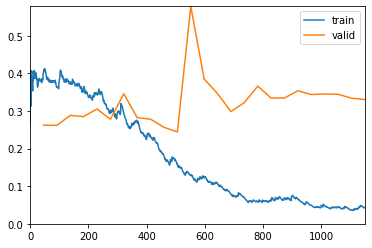

Better model found at epoch 0 with f_beta value: 0.9051474928855896.
Better model found at epoch 1 with f_beta value: 0.9254884123802185.
Better model found at epoch 10 with f_beta value: 0.9359375238418579.


In [9]:
train_model(64, 25, 25)

[INFO] Number of Classes:  2
[INFO] Training for :  densenet_128


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.791913,0.341204,0.884146,0.882570,00:17
1,0.648669,0.283065,0.896341,0.895216,00:15
2,0.596884,0.326142,0.878049,0.874387,00:15
3,0.540671,0.179323,0.926829,0.926126,00:15
4,0.554019,0.154778,0.926829,0.925488,00:15
5,0.482866,0.150394,0.939024,0.938281,00:15
6,0.501489,0.160909,0.920732,0.920063,00:15
7,0.512829,0.140110,0.939024,0.938104,00:15
8,0.483526,0.150660,0.926829,0.926292,00:15
9,0.455070,0.151978,0.932927,0.932198,00:15


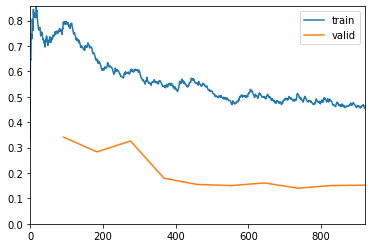

Better model found at epoch 0 with f_beta value: 0.8825701475143433.
Better model found at epoch 1 with f_beta value: 0.8952155113220215.
Better model found at epoch 3 with f_beta value: 0.9261261224746704.
Better model found at epoch 5 with f_beta value: 0.9382809400558472.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.506640,0.173289,0.951219,0.950152,00:18
1,0.491885,0.228335,0.902439,0.900651,00:18
2,0.476169,0.129579,0.951219,0.950751,00:18
3,0.445593,0.157938,0.945122,0.943593,00:18
4,0.409951,0.168795,0.945122,0.944375,00:18


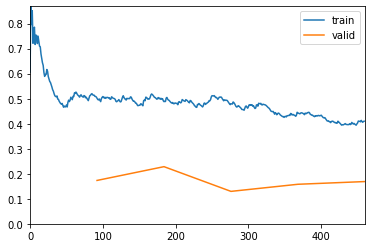

Better model found at epoch 0 with f_beta value: 0.9501519799232483.
Better model found at epoch 2 with f_beta value: 0.9507507681846619.


In [10]:
train_model(128, 10, 5, mixup=True)

[INFO] Number of Classes:  2
[INFO] Training for :  densenet_256


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.566153,0.215391,0.902439,0.893299,00:32
1,0.595620,0.196396,0.932927,0.928906,00:30
2,0.562112,0.182263,0.926829,0.922678,00:31
3,0.488626,0.206913,0.914634,0.911679,00:30
4,0.510674,0.180695,0.945122,0.941832,00:31
5,0.464601,0.176437,0.932927,0.928455,00:31
6,0.481012,0.177287,0.932927,0.927975,00:31
7,0.484639,0.165311,0.957317,0.955028,00:31
8,0.453031,0.159943,0.957317,0.955028,00:30
9,0.462030,0.163757,0.951219,0.948750,00:31


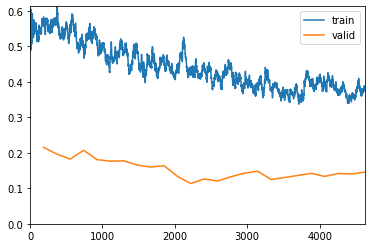

Better model found at epoch 0 with f_beta value: 0.8932986259460449.
Better model found at epoch 1 with f_beta value: 0.9289064407348633.
Better model found at epoch 4 with f_beta value: 0.9418324828147888.
Better model found at epoch 7 with f_beta value: 0.9550280570983887.
Better model found at epoch 11 with f_beta value: 0.9808343648910522.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.387665,0.134633,0.951219,0.949531,00:41
1,0.420272,0.105563,0.969512,0.968226,00:41
2,0.424173,0.126800,0.963415,0.961772,00:41
3,0.442106,0.171458,0.939024,0.936913,00:41
4,0.396818,0.156120,0.939024,0.936611,00:41
5,0.449131,0.228276,0.932927,0.928906,00:41
6,0.461543,0.220360,0.945122,0.942806,00:41
7,0.390439,0.109051,0.963415,0.961967,00:42
8,0.416713,0.113052,0.957317,0.955028,00:42
9,0.417509,0.113213,0.975610,0.974765,00:41


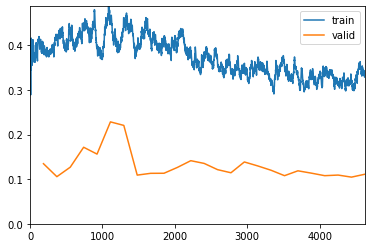

Better model found at epoch 0 with f_beta value: 0.9495307207107544.
Better model found at epoch 1 with f_beta value: 0.9682257175445557.
Better model found at epoch 9 with f_beta value: 0.974765419960022.


In [11]:
train_model(256, 25, 25, mixup=True)

[INFO] Number of Classes:  2
[INFO] Training for :  densenet_300


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.473374,0.048033,0.987805,0.986322,00:48
1,0.473167,0.045915,0.987805,0.986322,00:45
2,0.372269,0.042376,0.993902,0.993191,00:44
3,0.445006,0.052335,0.993902,0.993191,00:45
4,0.414578,0.045425,0.993902,0.993191,00:44
5,0.395589,0.057414,0.981707,0.979389,00:45
6,0.351177,0.044191,0.987805,0.986322,00:44
7,0.417751,0.061179,0.987805,0.986322,00:44
8,0.385164,0.062289,0.975610,0.972391,00:44
9,0.373246,0.068817,0.981707,0.979389,00:43


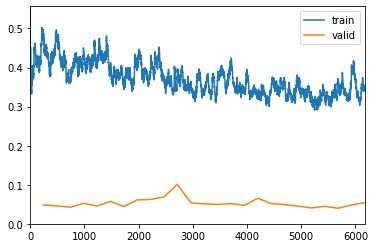

Better model found at epoch 0 with f_beta value: 0.9863219261169434.
Better model found at epoch 2 with f_beta value: 0.9931913614273071.


In [12]:
learn = create_cnn(get_data(300, (2048//300)), models.densenet161, 
                   metrics=[accuracy, FBeta(beta=1,average='macro')]).load("densenet_256")
learn.model_dir = "models/"
learn.mixup()
size = 300
name = "densenet_" + str(size)
print("[INFO] Training for : ", name)

learn.fit_one_cycle(25, 1e-4, callbacks=[ShowGraph(learn),
                          SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])

None

None

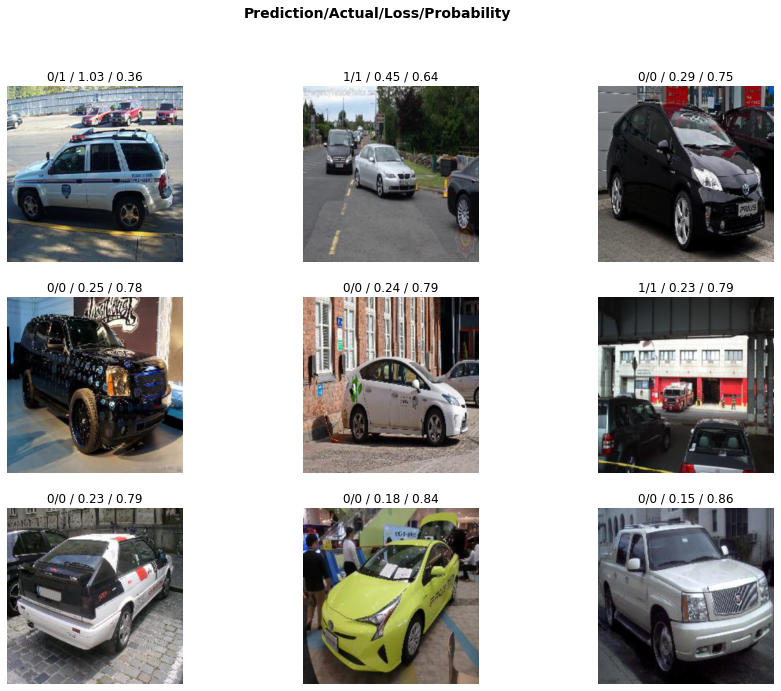

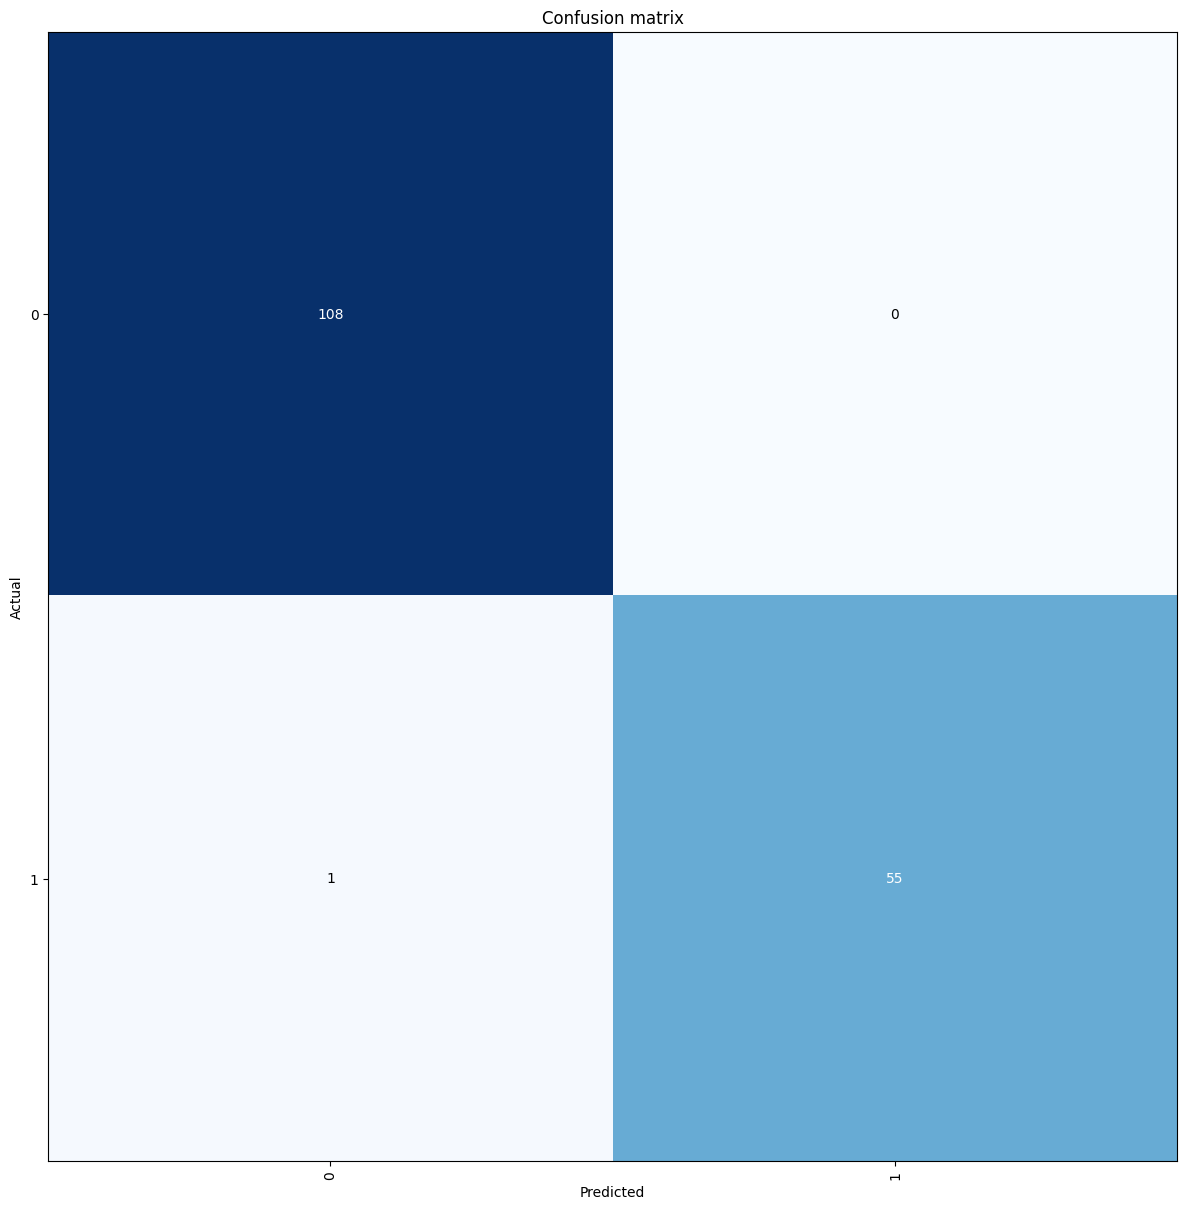

In [13]:
learn.load("densenet_300")
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

display(interp.plot_top_losses(9, figsize=(15,11)))
display(interp.plot_confusion_matrix(figsize=(12,12), dpi=100))

In [14]:
print("[INFO] MOST CONFUSED:")
interp.most_confused(min_val=5)

[INFO] MOST CONFUSED:


[]

In [0]:
def make_submission(learn, name):
  images = []
  prediction = []
  probability = []
  test_path = "/content/drive/My Drive/av/test"
  test = pd.read_csv("/content/drive/My Drive/av/sample_submission.csv")
  files = test.image_names
  for i in files:
        images.append(i)
        img = open_image(os.path.join(test_path, i))
        pred_class, pred_idx, outputs = learn.predict(img)
        prediction.append(pred_class.obj)
        probability.append(outputs.abs().max().item())
  answer = pd.DataFrame({'image_names': images, 'emergency_or_not': prediction})
  display(answer.head())
  answer[["image_names","emergency_or_not"]].to_csv(name, index=False)

In [16]:
make_submission(learn, name="submission_size300.csv")

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0
